In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Setup

In [311]:
df = pd.read_excel("stock_ardl3.xlsx")
df.index = pd.to_datetime(df.date)
df = df.loc[df.date > '2002-06-01']
#df['ibov'] = np.log(df['ibov'])
#df['exchange_rate'] = np.log(df['exchange_rate'])

# Exploratory analysis

In [312]:
def plot_acf_pacf(df_ts, lags=12):
    print(plot_acf(df_ts, lags=lags))
    print(plot_pacf(df_ts, lags=lags, method="ols"))

Figure(432x288)
Figure(432x288)


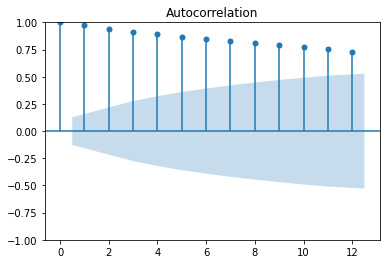

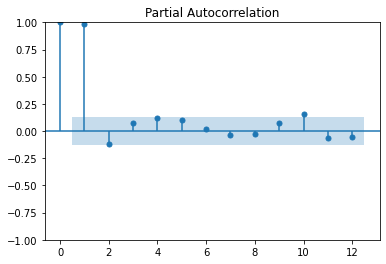

In [219]:
plot_acf_pacf(df.ibov)

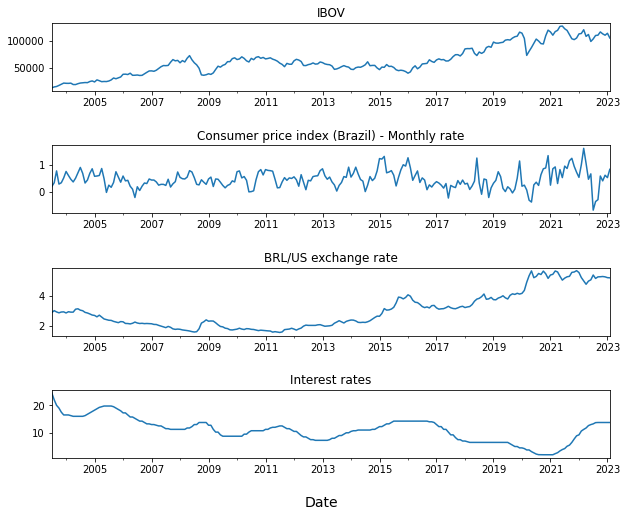

In [279]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8), gridspec_kw={'hspace': 0.8})

# Convert the index to datetime
df.index = pd.to_datetime(df.date)

# Plot each time series in a separate subplot
df['ibov'].plot(ax=axs[0], label='Series 1')
axs[0].set_title('IBOV')
df['cpi_inflation'].plot(ax=axs[1], label='Series 2')
axs[1].set_title('Consumer price index (Brazil) - Monthly rate')
df['exchange_rate'].plot(ax=axs[2], label='Series 3')
axs[2].set_title('BRL/US exchange rate')
df['interest_rates'].plot(ax=axs[3], label='Series 4')
axs[3].set_title('Interest rates')

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('')

fig.text(0.5, 0.04, 'Date', ha='center', fontsize=14)

# Display the plot
plt.show()

In [222]:
df[['ibov','cpi_inflation','exchange_rate','interest_rates']].describe()

,ibov,cpi_inflation,exchange_rate,interest_rates
count,236.000000,236.000000,236.000000,236.000000
mean,63623.529661,0.469569,2.993153,11.044449
std,27149.489423,0.329581,1.205691,4.360692
min,13572.000000,-0.680003,1.562500,2.000000
25%,47047.500000,0.259989,2.029225,7.937500
50%,58999.500000,0.449877,2.638250,11.250000
75%,76697.000000,0.647537,3.772875,13.750000
max,126802.000000,1.620050,5.654900,24.500000


# Engle-Granger cointegration test

In [280]:
from statsmodels.tsa.stattools import coint
engle_granger = coint(df['ibov'], df[['exchange_rate']])

print(
    f'''Engle-Granger statistic: {engle_granger[0]}'''
)
print(
    f'''p-value:{engle_granger[1]}'''
)

Engle-Granger statistic: -3.3806413752676163
p-value:0.04454657618926152


# ARDL model

$$ IBOV = \beta_0 + \beta_1logIBOV_{t-1} + \sum_{j=1}^{3} \alpha_jER_{t-j} + \sum_{j=1}^{3} \gamma_jCPI_{t-j} \sum_{j=1}^{3} \delta_jIR_{t-j} + \varepsilon_t

In [281]:
# Setting the exogenous variables
#exog=df.loc[:, ~df.columns.isin(["ibov", "date"])]
exog=df[['exchange_rate']]

# Define the range of lag values to test
max_lags = 6
lags_range = range(1, max_lags+1)

# Initialize the list of AIC values for each lag combination
aic_list = []

# Loop over the range of lags and fit the ARDL model for each combination
for p in lags_range:
    for q in lags_range:
        model = ARDL(
            df.ibov, p, 
            exog, {i:list(range(1,q+1)) for i in exog.columns})
        results = model.fit()
        aic = results.aic
        aic_list.append((p, q, aic))

# Find the combination of lags that returns the lowest AIC value
best_lags = min(aic_list, key=lambda x: x[2])
print("Best combination of lags: ({}, {}) with AIC = {}".format(best_lags[0], best_lags[1], best_lags[2]))

Best combination of lags: (6, 3) with AIC = 4530.106291233328


/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py

In [284]:
model = ARDL(
    df.ibov, best_lags[0], 
    exog, {i:list(range(1,best_lags[1]+1)) for i in exog.columns}
    ).fit(cov_type="HC0")
print(model.summary())

                              ARDL Model Results                              
Dep. Variable:                   ibov   No. Observations:                  236
Model:                     ARDL(6, 3)   Log Likelihood               -2254.053
Method:               Conditional MLE   S.D. of innovations           4364.647
Date:                Thu, 11 May 2023   AIC                           4530.106
Time:                        16:11:55   BIC                           4567.925
Sample:                    01-01-2004   HQIC                          4545.362
                         - 02-01-2023                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              623.5616    891.847      0.699      0.485   -1134.096    2381.219
ibov.L1              1.0544      0.101     10.396      0.000       0.854       1.254
ibov.L2             -0.0816 

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [285]:
max_used_lags = max(best_lags[0], best_lags[1])
model.model.exog = model.model.exog[max_used_lags:]

- Durbin-Watson test for residuals

In [286]:
import statsmodels.api as sm

# Test for first-order serial correlation using the Durbin-Watson test
durbin_watson = sm.stats.stattools.durbin_watson(model.resid)

# Print the test result
print("Durbin-Watson statistic:", durbin_watson)

Durbin-Watson statistic: 1.9875465770135667


- Breusch-Godfrey test for serial correlation

In [292]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

#perform Breusch-Godfrey test at order p = 3
breusch_godfrey = acorr_breusch_godfrey(model, nlags=3)

# Print the test result
print("Breusch-Godfrey statistic:", breusch_godfrey[0])
print("Breusch-Godfrey p-value:", breusch_godfrey[1])

Breusch-Godfrey statistic: 0.45632944854737567
Breusch-Godfrey p-value: 0.9283753809247539


- Breusch-Pagan for heteroskedasticity

In [293]:
# Add a constant column to your independent variable array
x_with_const = sm.add_constant(model.model.exog)

# Run the Breusch-Pagan test for heteroscedasticity
bp_test = sm.stats.diagnostic.het_breuschpagan(model.resid, x_with_const)

# Print the test results
print('Breusch-Pagan test statistic: ', bp_test[0])
print('Breusch-Pagan test p-value: ', bp_test[1])

Breusch-Pagan test statistic:  9.17969191364844
Breusch-Pagan test p-value:  0.002447152131531003


- Jarque-Bera test for residuals

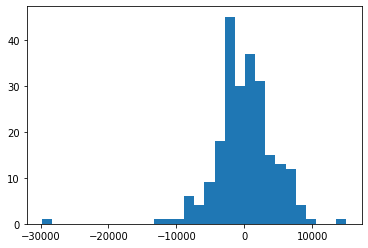

In [254]:
plt.hist(model.resid, bins=30)
fig = plt.gcf()
fig.set_facecolor("white")
plt.show()

In [255]:
import numpy as np
from scipy import stats

jarque_bera_test = stats.jarque_bera(model.resid)
jarque_bera_test

Jarque_beraResult(statistic=821.4781481769753, pvalue=0.0)

In [256]:
print(jarque_bera_test.statistic)
print(jarque_bera_test.pvalue)

821.4781481769753
0.0


# Augmented Ducky Fuller (ADF) TEST

A null hypothesis is given as:

* 𝐻0
  : Time series is not stationary
* 𝐻1
  : Time series is stationary


In [232]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput.apply(lambda x: round(x, 4)))

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [32]:
df.columns

Index(['date', 'ibov_returns', 'cpi_inflation', 'brl_dollar',
       'interest_rates'],
      dtype='object')

In [233]:
adf_test(df.ibov)

Results of Dickey-Fuller Test:
Test Statistic                  -1.1531
p-value                          0.6935
#Lags Used                       4.0000
Number of Observations Used    231.0000
Critical Value (1%)             -3.4590
Critical Value (5%)             -2.8741
Critical Value (10%)            -2.5735
dtype: float64


In [234]:
adf_test(df.cpi_inflation)

Results of Dickey-Fuller Test:
Test Statistic                  -7.8620
p-value                          0.0000
#Lags Used                       0.0000
Number of Observations Used    235.0000
Critical Value (1%)             -3.4585
Critical Value (5%)             -2.8739
Critical Value (10%)            -2.5734
dtype: float64


In [235]:
adf_test(df.interest_rates)

Results of Dickey-Fuller Test:
Test Statistic                  -2.4160
p-value                          0.1373
#Lags Used                       6.0000
Number of Observations Used    229.0000
Critical Value (1%)             -3.4592
Critical Value (5%)             -2.8742
Critical Value (10%)            -2.5735
dtype: float64


In [236]:
adf_test(df.exchange_rate)

Results of Dickey-Fuller Test:
Test Statistic                  -0.0218
p-value                          0.9567
#Lags Used                      14.0000
Number of Observations Used    221.0000
Critical Value (1%)             -3.4603
Critical Value (5%)             -2.8747
Critical Value (10%)            -2.5738
dtype: float64


# Bounds cointegration test

$$ \Delta IBOV = \beta_0 + \beta_1 \Delta IBOV_{t-1} + \phi_0 ER_{t-1} + \phi_1 CPI_{t-1} + \phi_2 IR_{t-1} + \sum_{j=0}^{4} \alpha_j \Delta ER_{t-j} + \sum_{j=0}^{4} \gamma_j \Delta CPI_{t-j} \sum_{j=0}^{4} \delta_j \Delta IR_{t-j} + \varepsilon_t

- Link to the paper on how to apply the bounds cointegration: https://www.scienpress.com/Upload/JSEM/Vol%205_4_3.pdf

In [294]:
df["residuals"] = model.resid
df["residuals_t_1"] = df.residuals.shift(1)
df

,date,cpi_inflation,exchange_rate,interest_rates,ibov,residuals,residuals_t_1
date,,,,,,,
2003-07-01,2003-07-01,0.199979,2.8833,24.50,13572,NaN,NaN
2003-08-01,2003-08-01,0.339974,3.0053,22.00,15174,NaN,NaN
2003-09-01,2003-09-01,0.780068,2.9204,20.00,16011,NaN,NaN
2003-10-01,2003-10-01,0.289921,2.8628,19.00,17982,NaN,NaN
2003-11-01,2003-11-01,0.340204,2.9150,17.50,20184,NaN,NaN
...,...,...,...,...,...,...,...
2022-10-01,2022-10-01,0.590078,5.2521,13.75,116037,6528.288844,-2698.125962
2022-11-01,2022-11-01,0.409961,5.2680,13.75,112486,-4219.090088,6528.288844
2022-12-01,2022-12-01,0.619968,5.2454,13.75,110031,-1900.070193,-4219.090088


In [295]:
var_list = ['ibov', 'cpi_inflation', 'exchange_rate', 'interest_rates']
# Use a list comprehension to calculate the first difference of each variable in the `var_list`
diffs = [df[var].diff() for var in var_list]

# Use the `concat()` method to combine the resulting differences into a new DataFrame
diff_data = pd.concat(diffs, axis=1)
diff_data.columns = [i+"_diff_1" for i in var_list]
diff_data

diff_data = pd.concat([df.reset_index(drop=True), diff_data.reset_index(drop=True)], axis=1)
diff_data

,date,cpi_inflation,exchange_rate,interest_rates,ibov,residuals,residuals_t_1,ibov_diff_1,cpi_inflation_diff_1,exchange_rate_diff_1,interest_rates_diff_1
0,2003-07-01,0.199979,2.8833,24.50,13572,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-08-01,0.339974,3.0053,22.00,15174,NaN,NaN,1602.0,0.139995,0.1220,-2.5
2,2003-09-01,0.780068,2.9204,20.00,16011,NaN,NaN,837.0,0.440094,-0.0849,-2.0
3,2003-10-01,0.289921,2.8628,19.00,17982,NaN,NaN,1971.0,-0.490147,-0.0576,-1.0
4,2003-11-01,0.340204,2.9150,17.50,20184,NaN,NaN,2202.0,0.050283,0.0522,-1.5
...,...,...,...,...,...,...,...,...,...,...,...
231,2022-10-01,0.590078,5.2521,13.75,116037,6528.288844,-2698.125962,6000.0,0.880114,0.0085,0.0
232,2022-11-01,0.409961,5.2680,13.75,112486,-4219.090088,6528.288844,-3551.0,-0.180118,0.0159,0.0
233,2022-12-01,0.619968,5.2454,13.75,110031,-1900.070193,-4219.090088,-2455.0,0.210008,-0.0226,0.0
234,2023-01-01,0.529959,5.1922,13.75,113532,3639.312919,-1900.070193,3501.0,-0.090010,-0.0532,0.0


In [296]:
diff_exog_variables = ['ibov', 'exchange_rate', 'cpi_inflation', 'interest_rates', 'cpi_inflation_diff_1','exchange_rate_diff_1','interest_rates_diff_1']

df_ecm_bounds = diff_data[['ibov', 'exchange_rate', 'cpi_inflation', 'interest_rates', 'ibov_diff_1', 'exchange_rate_diff_1', 'cpi_inflation_diff_1','interest_rates_diff_1']].dropna()

# Setting the exogenous variables
exog=df_ecm_bounds.loc[:, diff_exog_variables]
model_ecm_bounds = ARDL(
    df_ecm_bounds.ibov_diff_1, 6, 
    exog, {
        #'cpi_inflation':[1], 
        #'interest_rates':[1],
        'ibov':[1],
        'exchange_rate':[1], 
        'exchange_rate_diff_1':[1,2,3]
        #'cpi_inflation_diff_1':[1],
        #'interest_rates_diff_1':[1]
    }
).fit()
print(model_ecm_bounds.summary())

                              ARDL Model Results                              
Dep. Variable:            ibov_diff_1   No. Observations:                  235
Model:               ARDL(6, 1, 1, 3)   Log Likelihood               -2244.330
Method:               Conditional MLE   S.D. of innovations           4366.124
Date:                Thu, 11 May 2023   AIC                           4514.661
Time:                        16:18:45   BIC                           4559.299
Sample:                             6   HQIC                          4532.669
                                  235                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     688.1592    853.207      0.807      0.421    -993.474    2369.793
ibov_diff_1.L1              0.0975      0.077      1.268      0.206      -0.054       0.249


/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ardl/model.py:458: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: cpi_inflation_diff_1, interest_rates, interest_rates_diff_1, cpi_inflation.
  return _format_order(self.data.orig_exog, order, self._causal)


In [310]:
hypothesis = '(ibov.L1 = exchange_rate.L1 =0)'
f_test = model_ecm_bounds.f_test(hypothesis)

print(f"F-statistic of jointly significance: {f_test.fvalue}")
print(f"P-value: {f_test.pvalue}")

F-statistic of jointly significance: 3.5775662111627753
P-value: 0.0296038746432294


# ECM (error correction model)

$$ \Delta IBOV = \beta_0 + \beta_1 \Delta IBOV_{t-1} + \sum_{j=1}^{2} \alpha_j \Delta ER_{t-j} + \sum_{j=1}^{2} \gamma_j \Delta CPI_{t-j} \sum_{j=1}^{2} \delta_j \Delta IR_{t-j} + \varphi Z_{t-1} + \varepsilon_t

In [260]:
diff_data.dropna()

,date,cpi_inflation,exchange_rate,interest_rates,ibov,residuals,residuals_t_1,ibov_diff_1,cpi_inflation_diff_1,exchange_rate_diff_1,interest_rates_diff_1
7,2004-02-01,0.609857,2.9342,16.50,21755,-1974.511279,-2808.795755,-96.0,-0.149958,0.0809,0.00
8,2004-03-01,0.469884,2.9067,16.25,22142,-828.518710,-1974.511279,387.0,-0.139972,-0.0275,-0.25
9,2004-04-01,0.369922,2.9079,16.00,19607,-4969.757896,-828.518710,-2535.0,-0.099963,0.0012,-0.25
10,2004-05-01,0.509839,3.1023,16.00,19545,-1741.301050,-4969.757896,-62.0,0.139917,0.1944,0.00
11,2004-06-01,0.709805,3.1293,16.00,21149,-360.035207,-1741.301050,1604.0,0.199966,0.0270,0.00
...,...,...,...,...,...,...,...,...,...,...,...
231,2022-10-01,0.590078,5.2521,13.75,116037,6528.288844,-2698.125962,6000.0,0.880114,0.0085,0.00
232,2022-11-01,0.409961,5.2680,13.75,112486,-4219.090088,6528.288844,-3551.0,-0.180118,0.0159,0.00
233,2022-12-01,0.619968,5.2454,13.75,110031,-1900.070193,-4219.090088,-2455.0,0.210008,-0.0226,0.00
234,2023-01-01,0.529959,5.1922,13.75,113532,3639.312919,-1900.070193,3501.0,-0.090010,-0.0532,0.00


In [266]:
#diff_exog_variables = ['cpi_inflation_diff_1','exchange_rate_diff_1','interest_rates_diff_1', 'residuals_t_1']
diff_exog_variables = ['exchange_rate_diff_1','residuals_t_1']

df_ecm = diff_data[['ibov_diff_1', 'cpi_inflation_diff_1','exchange_rate_diff_1','interest_rates_diff_1', 'residuals_t_1']].dropna()

# Setting the exogenous variables
exog=df_ecm.loc[:, diff_exog_variables]
model_ecm = ARDL(
    df_ecm.ibov_diff_1, best_lags[0], 
    exog, {
        'exchange_rate_diff_1':[1,2,3],
        'residuals_t_1': [1]
        }
).fit()
print(model_ecm.summary())

                              ARDL Model Results                              
Dep. Variable:            ibov_diff_1   No. Observations:                  229
Model:                  ARDL(6, 3, 1)   Log Likelihood               -2188.792
Method:               Conditional MLE   S.D. of innovations           4430.524
Date:                Thu, 11 May 2023   AIC                           4401.584
Time:                        16:00:43   BIC                           4442.470
Sample:                             6   HQIC                          4418.090
                                  229                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      19.5030    350.790      0.056      0.956    -671.981     710.987
ibov_diff_1.L1              0.0477      0.078      0.608      0.544      -0.107       0.202


/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Bounds cointegration test

$$ \Delta IBOV = \beta_0 + \beta_1 \Delta IBOV_{t-1} + \phi_0 ER_{t-1} + \phi_1 CPI_{t-1} + \phi_2 IR_{t-1} + \sum_{j=0}^{4} \alpha_j \Delta ER_{t-j} + \sum_{j=0}^{4} \gamma_j \Delta CPI_{t-j} \sum_{j=0}^{4} \delta_j \Delta IR_{t-j} + \varepsilon_t

In [154]:
diff_data

,date,cpi_inflation,exchange_rate,interest_rates,ibov,residuals,residuals_t_1,ibov_diff_1,cpi_inflation_diff_1,exchange_rate_diff_1,interest_rates_diff_1
0,1998-01-01,0.709675,1.1199,42.90,9720,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-02-01,0.460322,1.1273,42.00,10571,NaN,NaN,851.0,-0.249352,0.0074,-0.90
2,1998-03-01,0.339698,1.1334,38.54,11947,NaN,NaN,1376.0,-0.120625,0.0061,-3.46
3,1998-04-01,0.239662,1.1409,36.55,11677,NaN,NaN,-270.0,-0.100036,0.0075,-1.99
4,1998-05-01,0.500099,1.1475,33.30,9847,NaN,NaN,-1830.0,0.260438,0.0066,-3.25
...,...,...,...,...,...,...,...,...,...,...,...
297,2022-10-01,0.590078,5.2521,13.75,116037,5050.960631,-1592.668813,6000.0,0.880114,0.0085,0.00
298,2022-11-01,0.409961,5.2680,13.75,112486,-2981.518156,5050.960631,-3551.0,-0.180118,0.0159,0.00
299,2022-12-01,0.619968,5.2454,13.75,110031,-1024.570946,-2981.518156,-2455.0,0.210008,-0.0226,0.00
300,2023-01-01,0.529959,5.1922,13.75,113532,4475.698297,-1024.570946,3501.0,-0.090010,-0.0532,0.00


In [155]:
diff_exog_variables = ['exchange_rate', 'cpi_inflation', 'interest_rates', 'cpi_inflation_diff_1','exchange_rate_diff_1','interest_rates_diff_1']

df_ecm_bounds = diff_data[['exchange_rate', 'cpi_inflation', 'interest_rates', 'ibov_diff_1', 'exchange_rate_diff_1', 'cpi_inflation_diff_1','interest_rates_diff_1']].dropna()

# Setting the exogenous variables
exog=df_ecm_bounds.loc[:, diff_exog_variables]
model_ecm_bounds = ARDL(
    df_ecm_bounds.ibov_diff_1, 5, 
    exog, {
        'exchange_rate':[1], 
        'cpi_inflation':[1], 
        'interest_rates':[1],
        'exchange_rate_diff_1':[1],
        'cpi_inflation_diff_1':[1],
        'interest_rates_diff_1':[1]}
).fit(cov_type="HAC", cov_kwds={'maxlags':2})
print(model_ecm_bounds.summary())

                                  ARDL Model Results                                 
Dep. Variable:                   ibov_diff_1   No. Observations:                  301
Model:             ARDL(5, 1, 1, 1, 1, 1, 1)   Log Likelihood               -2873.065
Method:                      Conditional MLE   S.D. of innovations           3973.338
Date:                       Thu, 11 May 2023   AIC                           5772.130
Time:                               13:50:05   BIC                           5820.104
Sample:                                    5   HQIC                          5791.338
                                         301                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -157.3630    934.033     -0.168      0.866   -1995.868    1681.142
ibov_diff_1.L1               0.06

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [214]:
model_ecm_bounds_RESTRICTED.resid.apply(lambda x: x**2).sum()

2.2375813059292247

In [215]:
model_ecm_bounds.resid.apply(lambda x: x**2).sum()

2.211917737056952

In [217]:
rrss = model_ecm_bounds_RESTRICTED.resid.apply(lambda x: x**2).sum()
urss = model_ecm_bounds.resid.apply(lambda x: x**2).sum()

print(f'Bounds cointegration F-test: {((rrss - urss)/1)/(urss/(296-20))}') ## The critical value is 3.1

Bounds cointegration F-test: 3.202264211765695


In [204]:
((rrss - urss)/3)/(urss/(296-20))

1.5748585053093505

- Durbin-watson serial correlation test

In [87]:
import statsmodels.api as sm

# Test for first-order serial correlation using the Durbin-Watson test
durbin_watson = sm.stats.stattools.durbin_watson(model_ecm.resid)

# Print the test result
print("Durbin-Watson statistic:", durbin_watson)

Durbin-Watson statistic: 2.013162758973414


- White test for heteroskedasticity test

In [94]:
# Add a constant column to your independent variable array
x_with_const = sm.add_constant(model_ecm.model.exog[2:])

# Run the Breusch-Pagan test for heteroscedasticity
bp_test = sm.stats.diagnostic.het_white(model_ecm.resid, x_with_const)

# Print the test results
print('White test statistic: ', bp_test[0])
print('White test p-value: ', bp_test[1])

White test statistic:  71.63951342300844
White test p-value:  9.7271690153347e-10


In [88]:
model_ecm.test_heteroskedasticity()

,ARCH-LM,P-value,DF
Lag,,,
1,10.346381,1.297288e-03,1
2,10.544726,5.131471e-03,2
3,32.385175,4.341100e-07,3
4,68.630616,4.415847e-14,4
5,94.627395,7.152547e-19,5
6,104.294201,3.183354e-20,6
7,92.700458,3.447036e-17,7
8,21.381550,6.200051e-03,8
9,12.312241,1.962735e-01,9
